# Balsam Tutorial Setup
----

## Installation

In a shell on Perlmutter:
```bash
source setup.sh --site NERSC
```

Follow the tutorial either via by executing the scripts provided in the repo, or via the Jupyter notebook.

### Scripts

To execute the scripts, run them in order as we progress:

```python 
python 0_application.py
python 1_define_jobs.py
python 2_submit_jobs.py <account>
```

### Notebook

Follow this link https://jupyter.nersc.gov/. 

## Setup Balsam site

In terminal on Perlmutter, log into balsam and create your site in a folder of your choosing:
```bash
balsam login
balsam site init -n nersc_tutorial nersc_tutorial
```

Now start the site:
```bash
cd nersc_tutorial
balsam site start
cd ..
```

## Balsam Command Line Commands

Balsam has a command line interface.  Some common commands we will use during this tutorial:

List your sites and their status:
```bash
balsam site ls
```

List the applications registered in your site:
```bash
balsam app ls
```

List the Jobs in your site and their statuses:
```bash
balsam job ls
```

List the Batch Jobs created by your site that are active:
```bash
balsam queue ls
```

List the Batch Jobs that have completed in your site:
```bash
balsam queue ls --history
```

## Documentation

The Balsam documentation can be viewed here: https://balsam.readthedocs.io/en/latest/

# Balsam LAMMPS Tutorial

This tutorial will show you how to setup a Balsam site and run simulations via Balsam. For this tutorial we are using the application `LAMMPS`, a large scale classical molecular dynamics code that stands for Large-scale Atomic/Molecular Massively Parallel Simulator. 

## Create Balsam Application

Save your site name to ```site_name```.
Get the absolute path to the demo Balsam directory in ```demo_path```.

In [1]:
import os
site_name = "nersc_tutorial"
demo_path = os.getcwd()
application_env = os.path.join(demo_path,"lammps_envs.sh")
input_file_path = os.path.join(demo_path,"lj_lammps_template.in")
application_env

'/home/csimpson/polaris/DOE-HPC-workflow-training/Balsam/ALCF/lammps_envs.sh'

We can also create the application running this script at the command line:
```shell
python 0_application.py
```

In [2]:
from balsam.api import ApplicationDefinition

class Lammps(ApplicationDefinition):

    site = site_name
            
    def shell_preamble(self):
        return 'source '+application_env


    command_template = 'lmp -in {{input_file_path}} -k on g {{NGPUS}} -var tinit {{tinit}} -var lat_scale {{lat_scale}} -sf kk -pk kokkos neigh half neigh/qeq full newton on'
    
        
    def postprocess(self):
        print("starting postprocess")
        try:
            with open("energy.dat","r") as f:
                for line in f:
                    pass
                line_entries = line.split()
                if line_entries[0] == "1000":
                    self.job.data = {"tfinal":float(line_entries[3]), "efinal":float(line_entries[1])+float(line_entries[2]), "Pfinal":float(line_entries[4])}
                    self.job.state = "POSTPROCESSED"
                else:
                    self.job.state = "FAILED"
        except:
            self.job.state = "FAILED"       

Lammps.sync()

# Create Balsam Jobs

Then we create the Balsam Jobs.  We can also do this via this script:

```python
python 1_define_jobs.py 
```

In [10]:
from balsam.api import Job
import numpy as np

# There are 4 GPUs on a Perlmutter node
n_gpus = 4 

lat_scales = np.arange(0.15,0.85,0.05)

jobs = [Job(app_id="Lammps",
            site_name=site_name,
            workdir=f"LJ/{n}",
            parameters={"NGPUS": n_gpus,"tinit":1.5, 
                        "lat_scale": lat_scale,
                        "input_file_path":input_file_path},
            num_nodes=1,
            ranks_per_node=n_gpus,
            gpus_per_rank=1,
            threads_per_core=2,
            threads_per_rank=32,
            launch_params={"gpu-bind":"none"},
            tags={"parameter_test":"density"},
        )
        for n,lat_scale in enumerate(lat_scales)]

jobs = Job.objects.bulk_create(jobs)

# Submit Balsam Jobs

Then we submit the Balsam jobs to the scheduler on the machine where we are running.  We can also do this by running this script.

```shell
python 2_submit_jobs.py <account>
```


In [4]:
from balsam.api import BatchJob, Site

site_name = site_name
site = Site.objects.get(site_name)
account = "<insert-account>"

BatchJob.objects.create(
    site_id=site.id,
    num_nodes=2,
    wall_time_min=10,
    job_mode="mpi",
    project=account,
    queue="regular"
)

BatchJob(num_nodes=2, wall_time_min=10, job_mode=mpi, optional_params={}, filter_tags={}, partitions=None, id=11935, site_id=492, scheduler_id=None, project=WALSforAll, queue=debug, state=pending_submission, status_info={}, start_time=None, end_time=None)

# Plot Results

We will now pull results from our jobs and plot them.  The input parameter was a measure of the density of the particle distribution we have simulated.  We will plot the final pressure and temperature vs. density.  Our application saved the final temperature and pressure in the data field of the jobs via the postprocess routine.

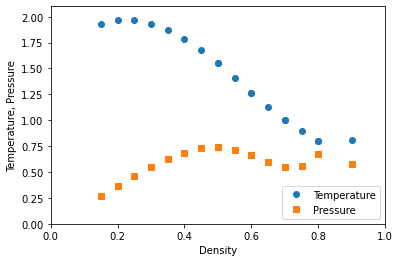

In [122]:
import matplotlib.pyplot as plt

finished_jobs = Job.objects.filter(state="JOB_FINISHED",site_id=site.id,tags={"parameter_test":"density"})

if finished_jobs.count() > 0:
    efinal = []
    tfinal = []
    density = []
    Pfinal = []
    tinit = []
    for j in finished_jobs:

        efinal.append(j.data['efinal'])
        tfinal.append(j.data['tfinal'])
        Pfinal.append(j.data['Pfinal'])
        density.append(j.get_parameters()['lat_scale'])
        tinit.append(j.get_parameters()['tinit'])

    plt.plot(density,tfinal,'o',label="Temperature")
    plt.plot(density,Pfinal,'s',label="Pressure")
    plt.ylim(0,2.1)
    plt.xlim(0,1)
    plt.ylabel("Temperature, Pressure")
    plt.xlabel("Density")
    plt.legend(loc=0)
    plt.savefig("lammps_phases.png")

# Job Dependencies and Multi-site workloads

Now we will show how to create dependencies between jobs and how to deploy those jobs across multiple machines.  

We have already run several Lammps jobs on Perlmutter.  We will now create a job that is dependent on the outcome of those jobs that will run on Polaris, a machine at ALCF.  The dependent job will fit a spline curve to the data plotted in the last section. 

To create the spline fitting application on Polaris we must first create and start a site on Polaris at ALCF.  We won't demo this step live, but users can follow the same the steps that they followed to create a site on Polaris outlined at the top of this notebook.  

We will introduce one difference in our Cori site, and that is we will activate elastic queuing in the site.  This is a mode where a site will automatically create batch jobs on the scheduler when the site has jobs ready to run.

One note: we use the Job data field to communicate small amounts of data between sites.  For larger amounts of data between sites, jobs should use Globus for data transfers: https://balsam.readthedocs.io/en/latest/user-guide/transfer/.  The Balsam server is not suited to large data transfers.


## Setup Elastic Queuing

To set the site in elastic queuing mode, open the `settings.yml` file in the site directory.  You will find a commented out section for elastic queing.  Uncomment it, and change the parameter values so that it looks like this:

```
# Elastic Queue flexibly sizes and requests BatchJobs based on the net
# job requirements 
# elastic_queue: null
elastic_queue:
     service_period: 60  # Calculate and submit 1 BatchJob per `service_period` seconds
     submit_project: "WALSforAll"
     submit_queue: "debug"
     job_mode: "mpi"
     use_backfill: False # Constrains BatchJobs to fit into idle backfill slots
     min_wall_time_min: 10  # If `use_backfill`, ignore windows shorter than this duration
     max_wall_time_min: 10 # If not `use_backfill`, submit BatchJobs for this walltime limit
     wall_time_pad_min: 0 # Subtract this walltime duration from all submitted BatchJobs
     min_num_nodes:  1 # Do not request fewer than this many nodes
     max_num_nodes: 1 # Do not request more than this many nodes
     max_queue_wait_time_min: 10 # Delete BatchJobs waiting in queue for this long
     max_queued_jobs: 5 # Maximum number of simultaneously queued jobs

```

After you have changed the `settings.yml` file, run the command `balsam site sync` in the site directory to adopt these changes.

## Create the Application

Next create the application.  Even thoug our 

In [120]:
site_name = "polaris_tutorial"

from balsam.api import ApplicationDefinition

class FitSpline(ApplicationDefinition):

    site = site_name
    
    def preprocess(self):
        try:
            parent_density = [ j.get_parameters()["lat_scale"]
                for j in self.job.parent_query()]
            parent_tfinal = [ j.data["tfinal"]
                for j in self.job.parent_query()]
            self.job.data={"density":parent_density,"tfinal":parent_tfinal}
        
            self.job.state = "PREPROCESSED"
        except:
            self.job.state = "FAILED"
        
    
    # This routine demonstrates an alternative way of defining an application.  This method, using the function run,
    # wraps around python code. Instead of the command_template, the executable is `python run()`.  
    # The function run will be run on the compute nodes just like command_template.
    def run(self):
        from scipy.interpolate import CubicSpline
        import numpy as np
        
        isort = np.argsort(self.job.data['density'])
        x = np.array(self.job.data['density'])[isort]
        y = np.array(self.job.data['tfinal'])[isort]
        cs = CubicSpline(x,y) 
        
        # Run applications can return objects that can be accessed later through the job instance.
        return cs    

FitSpline.sync()

## Define a Job dependency

We want the FitSpline job to use the data from the Lammps johs and we only want it to execute after those jobs have successfully finished.  We introduce this dependency through the ``parent_ids`` keyword that makes this job dependent on it's parents.  Below ``lammps_job_ids`` contains the job ids of the Lammps application jobs we ran on Polaris.  

In [111]:
lammps_job_ids = [job.id for job in jobs]
fitting_job = FitSpline.submit(workdir="LJ/spline", parent_ids=lammps_job_ids)

## Collect results from python application

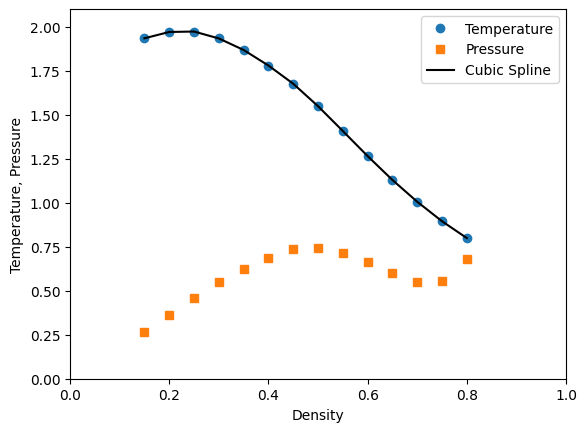

In [12]:
if fitting_job.result():
    cs = fitting_job.result()
    plt.plot(density,tfinal,'o',label="Temperature")
    plt.plot(density,Pfinal,'s',label="Pressure")
    plt.plot(density, cs(density), label="Cubic Spline",c="k")
    plt.ylim(0,2.1)
    plt.xlim(0,1)
    plt.ylabel("Temperature, Pressure")
    plt.xlabel("Density")
    plt.legend(loc=0)
    plt.savefig("lammps_phases_fit.png")